## Some code for Implementing MLE estimation with pytorch

### 1. Data Generation

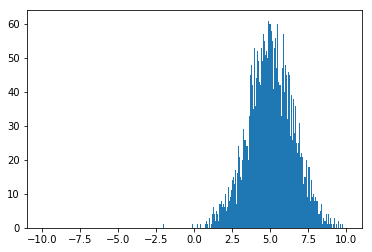

In [1]:
import torch
torch.manual_seed(100)
from torch import nn
from torch.nn import functional as F
from torch.distributions import Normal
from matplotlib import pyplot as plt
%matplotlib inline
# specify mean and std
desired_mean = 5.0
desired_var = 1.5
# create our distribution
desired_dist = Normal(loc=desired_mean, scale=desired_var)
# generate some data and plot
samples = (desired_dist.sample((5000,))).numpy()
plot = plt.hist(samples, bins=500, range=(-10, 10),)

### 2. Maximum Likelihood Estimate (MLE) with Gradient Descent

Here we will create a simple linear layer with a single gaussian output, and fit it via maximum likelihood Estimate.

In [2]:
class simple_gaussian_net(nn.Module):
    def __init__(self, hidden_size=5):
        super().__init__()
        # input to hidden
        self.i2h = nn.Linear(1, hidden_size)
        # hidden to mean
        self.h2mean = nn.Linear(hidden_size, 1)
        # hidden to std
        self.h2std = nn.Linear(hidden_size, 1) 
        
    def forward(self, x):
        """forward pass returns the distribution, the mean and variance
        
        """
        x = self.i2h(x)
        mean = self.h2mean(x)
        # std needs to be positive, so use softplus to ensure positive
        std = F.softplus(self.h2std(x))
        # create our normal distribution
        dist = Normal(mean, std)
        
        return dist, mean, std
    
# create input data, note that the input data should be fixed for training.
train_x = 0.5

# create model
model = simple_gaussian_net(5)

let's generate some samples from our simple gaussian network and see what the mean/var and plot looks like

initial gaussian mean:tensor([0.1852]), initial var:tensor([0.4641])


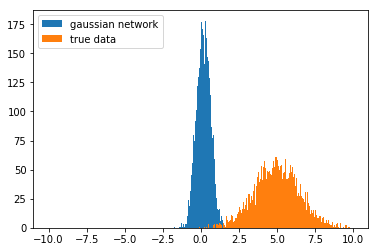

In [3]:
with torch.no_grad():
    some_x = torch.ones(5000,1) * train_x
    dist, mean, var = model.forward(some_x)
    # sample from the mean and var
    sample = dist.sample()
    print("initial gaussian mean:{}, initial var:{}".format(mean.detach()[0], var.detach()[0]))
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.hist(sample.numpy(), bins=500, range=(-10,10), label="gaussian network")
    ax1.hist(samples, bins=500, range=(-10, 10), label="true data")
    plt.legend(loc="upper left")
    

Great! Now we can see from the plots that the our gaussian net is centered around 0, where as our desired gaussian is centered around 5 and has a much larger variance.

Let's start our MLE estimate, here are the steps:

1. create optimizer
2. generate data from true distribution, and increase the likelihood (i.e loss should be -likelihood)
3. take gradient step

For visualzation purposes, we will periodically plot the network's output distributions as we're doing MLE estimate

In [4]:
# 1. reset network and create optimizer
model = simple_gaussian_net(5)
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)

total_iters = 10000
every_iter = 1000

# sample_storage
storage = []

for i in range(total_iters):
    # sample from true distribution
    y = desired_dist.sample()
    # forward pass through our network and get distribution, then compute the likelihood of seeing the true sample
    dist, _, _ = model.forward(torch.ones(1,1)*train_x)
    likelihood = dist.log_prob(y)
    # note loss should be negative log likelihood, since optimizer always minimizes (thus we maximize the likelihood)
    loss = (-likelihood).sum()
    # optimzation step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # sample from our distribution periodically and store data
    if i % every_iter == 0:
        with torch.no_grad():
            d, m, v = model.forward(torch.ones(5000,1)*train_x)
            s = d.sample()
            storage.append([s, m.numpy()[0], v.numpy()[0]])
    

### Visualization

Below we visualize all the plots our network has as it learns on the same plot, we can see by closely observing the legend as well as as looking at the mean and std values that our network slowly moves to fit to the true distribution.

mean:[0.07265803], std:[0.6536591]
mean:[1.2080619], std:[1.2075845]
mean:[2.2193182], std:[1.6888403]
mean:[3.0601492], std:[1.9850197]
mean:[3.8041859], std:[2.106259]
mean:[4.4057183], std:[2.0573175]
mean:[4.816628], std:[1.8750242]
mean:[4.9120836], std:[1.6439452]
mean:[4.9406366], std:[1.5265577]
mean:[4.9087925], std:[1.4775324]


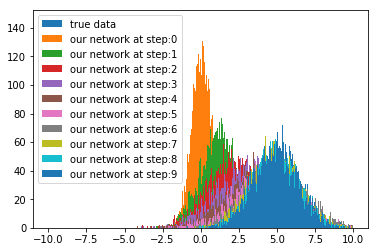

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.hist(samples, bins=500, range=(-10, 10), label="true data")

for idx, item in enumerate(storage):
    print("mean:{}, std:{}".format(item[1], item[2]))
    ax1.hist(item[0].numpy(), bins=500, range=(-10, 10), label="our network at step:{}".format(idx))
    plt.legend(loc="upper left")
    
    
    

## Alternative visualization

here we create a single plot for each time step to see how our gaussian network is moving closer to the network.

mean:[0.07265803], std:[0.6536591]
mean:[1.2080619], std:[1.2075845]
mean:[2.2193182], std:[1.6888403]
mean:[3.0601492], std:[1.9850197]
mean:[3.8041859], std:[2.106259]
mean:[4.4057183], std:[2.0573175]
mean:[4.816628], std:[1.8750242]
mean:[4.9120836], std:[1.6439452]
mean:[4.9406366], std:[1.5265577]
mean:[4.9087925], std:[1.4775324]


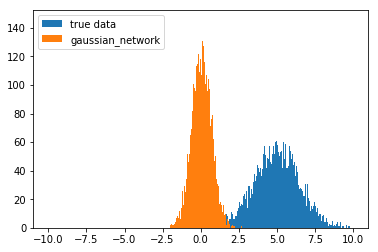

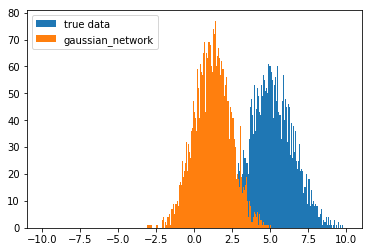

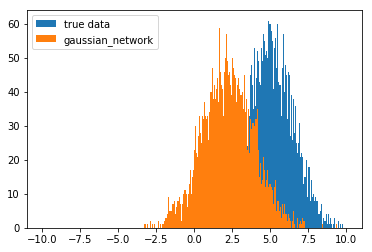

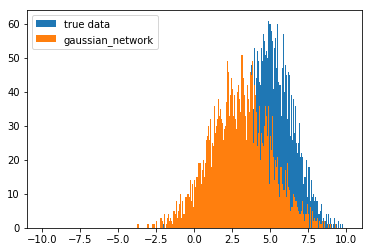

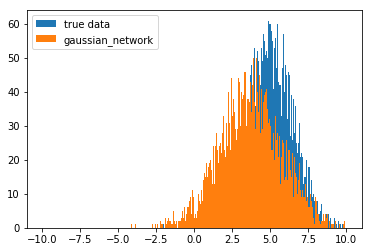

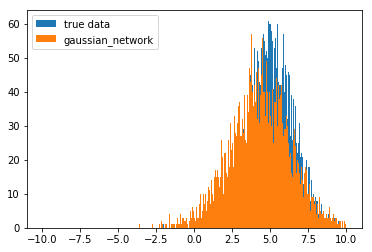

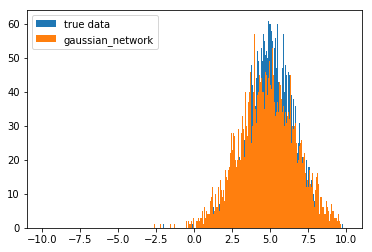

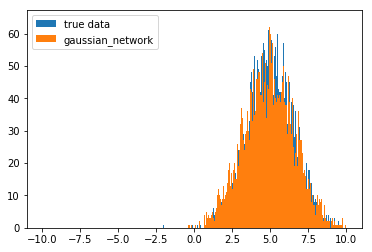

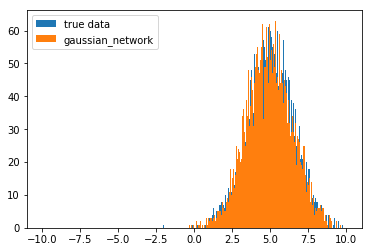

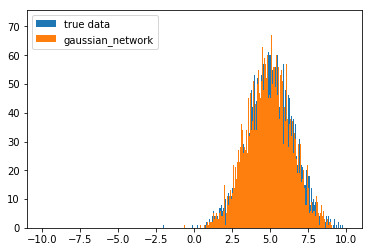

In [27]:
for idx, item in enumerate(storage):
    print("mean:{}, std:{}".format(item[1], item[2]))
    #plt.subplot(5, 2, idx+1)
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    ax1.hist(samples, bins=500, range=(-10, 10), label="true data")
    ax1.hist(item[0].numpy(), bins=500, range=(-10, 10), label="gaussian_network")
    plt.legend(loc="upper left")
    


In [ ]:
fig = plt.subplot

In [ ]:
fig = plt.figure